# Analitic model for single qubit

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import random
from tqdm import tqdm
import pickle
from matplotlib import pyplot as plt

df = pd.read_excel('09-1216A-A_DW_2000Q_6_annealing_schedule.xls', sheet_name=1)
nominal_temp_ghz = 13.5 / 47.9924341590788

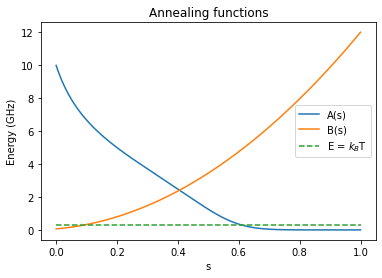

In [2]:
plt.figure()
plt.plot(df['s'], df['A(s) (GHz)'], label='A(s)')
plt.plot(df['s'], df['B(s) (GHz)'], label='B(s)')
plt.plot(np.linspace(0,1), nominal_temp_ghz * np.ones(50), linestyle='--', label='E = $k_B$T')

plt.title('Annealing functions')
plt.xlabel('s')
plt.ylabel('Energy (GHz)')
plt.legend()
plt.show()

## Last time results

In [3]:
biases, n_spin_up, dn_spin_up = pickle.load(open("data/results.pickle", "rb"))

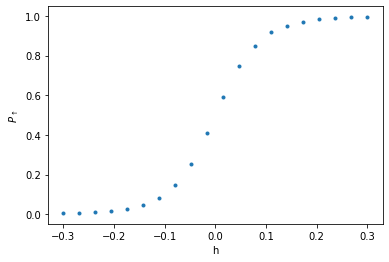

In [4]:
# grafico popolaz ground state vs h
plt.figure()
plt.errorbar(biases, n_spin_up, dn_spin_up, marker='.', linestyle='')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.show()

## Solving Schroedinger eq: analitic solution at T=0

$$ \mathcal{H}_{\text{single qubit}} = - \frac{A(s)}{2} \hat{\sigma}_x + \frac{B(s)}{2} h \hat{\sigma}_z $$

Considering a linear ramping of s with time (from $t_i=0$ to $t_f = 20 \mu s$)

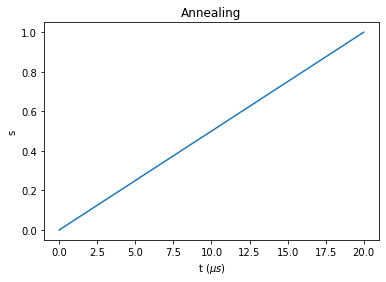

In [5]:
# linear foward anneal schedule
plt.figure()
plt.plot([0, 20], [0, 1])
plt.title('Annealing')
plt.xlabel('t ($\mu s$)')
plt.ylabel('s')
plt.show()

$$ i \hbar \frac{\partial}{\partial t} | \psi(t) \rangle = H(t) | \psi (t) \rangle $$

We can numerically solve schroedinger equation:
$$ | \psi(t+dt) \rangle = | \psi(t) \rangle - \frac{i}\hbar dt H(t) | \psi (t) \rangle $$

We need to choose a time interval $dt$ small such that $dt \times H(t) / \hbar << 1$.

Remebering that $H(t) / \hbar \sim 5 GHz$, we need $dt < 2 \times 10^{-10} s$

In [24]:
# hamiltonian
def hamilt(A, B, h):
    return - A / 2 * np.array([[0, 1], [1, 0]]) + h * B / 2 * np.diag([1, -1])  # GHz

In [71]:
# numerical solution of schroedinger eq

def schroedinger_evolution(h, t_final=20):
    '''
    Given h (bias) and t_final, this function initialises a state in the ground state
    of the system at t=0 and let it evolve according to Schroedinger equation.
    Return the final state after evolution.
    '''
    # keep track of the error during evolution
    err = 0
    
    # find optimal dt
    dt_estimate = 0.2  # nano seconds
    N = int(1000 * t_final * (df.loc[1,'s'] - df.loc[0, 's']) / dt_estimate + 1)
    
    # compute initial state: the ground state of system
    H_init = hamilt(df.loc[0, 'A(s) (GHz)'], df.loc[0, 'B(s) (GHz)'], h)
    v, w = np.linalg.eigh(H_init)
    psi = w[0]  # initial state of evolution
    
    # perform evolution    
    for s_index in range(len(df) - 1):
        dt = 1000 * t_final * (df.loc[s_index + 1,'s'] - df.loc[s_index, 's']) / N  # nano seconds
        A_initial = df.loc[s_index, 'A(s) (GHz)']
        B_initial = df.loc[s_index, 'B(s) (GHz)']
        A_final = df.loc[s_index + 1, 'A(s) (GHz)']
        B_final = df.loc[s_index + 1, 'B(s) (GHz)']
    
        for jj in range(N):
            x = jj / N  # initial
            Ai = (A_initial * (1-x) + A_final * x)
            Bi = (B_initial * (1-x) + B_final * x)
            
            x = (jj + 0.5) / N  # middle
            Am = (A_initial * (1-x) + A_final * x)
            Bm = (B_initial * (1-x) + B_final * x)
            
            x = (jj + 1) / N  # final
            Af = (A_initial * (1-x) + A_final * x)
            Bf = (B_initial * (1-x) + B_final * x)
            
            # 4th order Runge-Kutta
            k1 = - 1j * dt * np.dot(hamilt(Ai, Bi, h), psi)
            k2 = - 1j * dt * np.dot(hamilt(Am, Bm, h), psi + k1 / 2)
            k3 = - 1j * dt * np.dot(hamilt(Am, Bm, h), psi + k2 / 2)
            k4 = - 1j * dt * np.dot(hamilt(Af, Bf, h), psi + k3)

            # psi updated
            psi = psi + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
            
            # check and correct normalization
            err += (1 - np.linalg.norm(psi)) ** 2
            psi = psi / np.linalg.norm(psi)
    
    return psi, err

In [86]:
# define f, t_f for schroedinger solution
t_final = 0.03  # mu s

biases_teo = np.logspace(-9, -0.5, 10)
biases_teo = sorted(np.concatenate((-biases_teo, biases_teo)))

biases_teo = np.linspace(-10 ** (-0.5), 10 ** (-0.5), 100)

# perform numerical calulation
psi_list = []
for h in tqdm(biases_teo):
    psi, err = schroedinger_evolution(h, t_final)
    psi_list.append(abs(psi[1]) ** 2)

print(f'Error estimate: {err}')
pickle.dump((biases_teo, psi_list), open(f"data/schroedinger{str(t_final)}.pickle", "wb"))

100%|██████████| 100/100 [00:16<00:00,  5.90it/s]

Error estimate: 1.0376216780331924e-13


0.5000000000000001


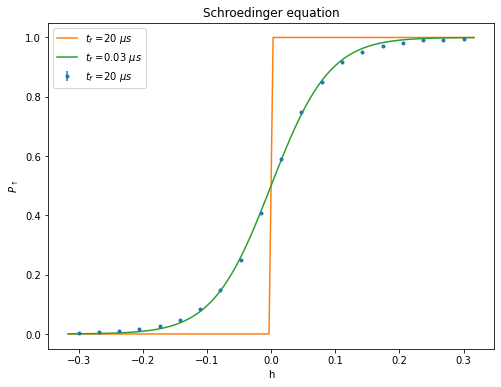

In [91]:
# opening saved data
biases_teo0, spin_up_teo0 = pickle.load(open("data/schroedinger20.pickle", "rb"))
biases_teo1, spin_up_teo1 = pickle.load(open("data/schroedinger0.03.pickle", "rb"))

print((spin_up_teo3[49] + spin_up_teo3[50]) / 2)

# grafico popolaz ground state vs h, experiment and theory
plt.figure(figsize=(8, 6))
plt.errorbar(biases, n_spin_up, dn_spin_up, marker='.', linestyle='', label='$t_f$ =20 $\mu s$')
plt.plot(biases_teo0, spin_up_teo0, label='$t_f$ =20 $\mu s$')
plt.plot(biases_teo1, spin_up_teo1, label='$t_f$ =0.03 $\mu s$')

plt.title('Schroedinger equation')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

## Lindbladian: considering thermal noise

$$ \dot{\rho} = -i \left[ \mathcal{H}, \rho \right] + \sum_k \left( L_k \rho L_k ^ \dagger - \frac{1}{2} L_k^\dagger L_k \rho - \frac{1}{2} \rho L_k^\dagger L_k \right) $$

Con $ \{ L_k \}_{k=1}^{d^2-1} $ operatori di Linblad, base ortogonale a traccia nulla.

In [114]:
def D_one_lind_op(theta, L):
    D = np.dot(np.dot(L, theta), L.T.conj())
    D -= np.dot(np.dot(L.T.conj(), L), theta) / 2
    D -= np.dot(np.dot(theta, L.T.conj()), L) / 2

    return D


def lindblad_op(rho, A, B, h, l1, l2, l3):

    L1 = np.array([[0, 1], [0, 0]])
    L2 = np.array([[0, 0], [1, 0]])
    L3 = np.diag([1, -1]) / np.sqrt(2)
    
    hamiltonian = hamilt(A, B, h)
    l_rho = -1j * (np.dot(hamiltonian, rho) - np.dot(rho, hamiltonian))
    l_rho = l_rho + l1 * D_one_lind_op(rho, L1) + l2 * D_one_lind_op(rho, L2) + l3 * D_one_lind_op(rho, L3)
    
    return l_rho  # return rho / 1 GHz

In [118]:
# density matrix evolution with lindblad

def lindblad_evolution(h, t_final=20, lindblad_coeff = [0, 0, 0]):
    '''
    Given h (bias) and t_final, this function initialises a state in the ground state
    of the system at t=0 and let it evolve according to Lindblad master equation.
    With L{k} just operators and l{k} real coefficients.
    Return the final density matrix after evolution.
    '''
    # unpack coeff
    l1, l2, l3 = lindblad_coeff
    
    # keep track of the error during evolution
    err = 0
    
    # find optimal dt
    dt_estimate = 0.2  # nano seconds
    N = int(1000 * t_final * (df.loc[1,'s'] - df.loc[0, 's']) / dt_estimate + 1)
    
    # compute initial state (ground state) of system
    H_init = hamilt(df.loc[0, 'A(s) (GHz)'], df.loc[0, 'B(s) (GHz)'], h)
    v, w = np.linalg.eigh(H_init)
    psi = w[0]
    alpha = psi[0]
    beta = psi[1]
    
    # initial density matrix of the system
    rho = np.array([[abs(alpha)**2, alpha * np.conjugate(beta)], [beta * np.conjugate(alpha), abs(beta) ** 2]])
    
    # debugging, pls ignore next lines:
    fix1 = []
    fix2 = []
    
    # actual evolution
    for s_index in range(len(df) - 1):
        dt = 1000 * t_final * (df.loc[s_index + 1,'s'] - df.loc[s_index, 's']) / N
        A_initial = df.loc[s_index, 'A(s) (GHz)']
        B_initial = df.loc[s_index, 'B(s) (GHz)']
        A_final = df.loc[s_index + 1, 'A(s) (GHz)']
        B_final = df.loc[s_index + 1, 'B(s) (GHz)']
    
        for jj in range(N):
            x = jj / N  # initial
            Ai = (A_initial * (1-x) + A_final * x)
            Bi = (B_initial * (1-x) + B_final * x)
            
            x = (jj + 0.5) / N  # middle
            Am = (A_initial * (1-x) + A_final * x)
            Bm = (B_initial * (1-x) + B_final * x)
            
            x = (jj + 1) / N  # final
            Af = (A_initial * (1-x) + A_final * x)
            Bf = (B_initial * (1-x) + B_final * x)
            
            # 4th order Runge-Kutta
            k1 = - dt * lindblad_op(rho, Ai, Bi, h, l1, l2, l3)
            k2 = - dt * lindblad_op(rho + k1 / 2, Am, Bm, h, l1, l2, l3)
            k3 = - dt * lindblad_op(rho + k2 / 2, Am, Bm, h, l1, l2, l3)
            k4 = - dt * lindblad_op(rho + k3, Af, Bf, h, l1, l2, l3)

            rho = rho + k1 / 6 + k2 / 3 + k3 / 3 + k4 / 6
            err += (1 - np.trace(rho)) ** 2
            
        fix1.append(df.loc[s_index, 's'])
        fix2.append(rho)
            
    print(err)
    return fix1, fix2

In [137]:
h = 0.1
l1 = 0  # GHz
l2 = 0  # GHz
l3 = 0.0001  # GHz
t_final = 20  # mu s

s, rho = lindblad_evolution(h, t_final, [l1, l2, l3])
s = np.array(s)
rho = np.array(rho)

(8.586900622431147e-23+0j)


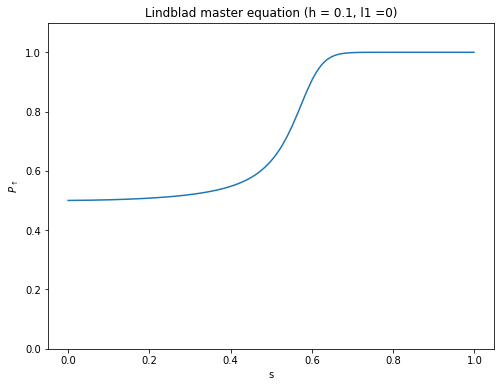

In [136]:
up = [abs(i[1, 1]) for i in rho]

# grafico popolaz ground state during evolution
plt.figure(figsize=(8, 6))
plt.plot(s, up)
plt.ylim([0, 1.1])

plt.title(f'Lindblad master equation (h = {h}, l1 ={l1})')
plt.xlabel('s')
plt.ylabel(r'$P_\uparrow$')

plt.show()

In [110]:
# misuro rho sullo stato (0, 1)
# measure = abs(np.trace(np.dot(myrho, np.array([[0, 0], [0, 1]]))))
measure = abs(myrho[1, 1])
measure

764233.2640711678

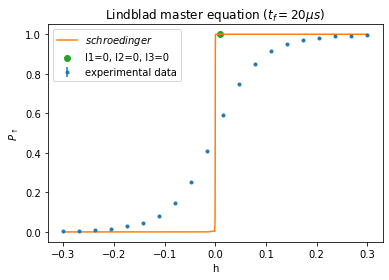

In [59]:
# grafico popolaz ground state vs h
plt.figure()
plt.errorbar(biases, n_spin_up, dn_spin_up, marker='.', linestyle='', label='experimental data')
plt.scatter([h], [measure], color='C2', label='l1=0, l2=0, l3=0')
plt.plot(biases_teo0, spin_up_teo0, color='C1', label='$schroedinger$')

plt.title('Lindblad master equation ($t_f=20 \mu s$)')
plt.xlabel('h')
plt.ylabel(r'$P_\uparrow$')
plt.legend()
plt.show()

For a reason I don't understant, it doesn't converge

## Resonance

In [ ]:
# cerco quali device sono disponibili al momento
from dwave.cloud import Client

with Client.from_config() as client:
    for solver in client.get_solvers():
        print(solver.id)

In [ ]:
# scelgo il device e mi assicuro di poterci comunicare, stampo a schermo alcune caratteristiche
from dwave.system import DWaveSampler
import dwave.inspector

sampler = DWaveSampler(solver='DW_2000Q_6')

print(f'Maximum anneal-schedule points: {sampler.properties["max_anneal_schedule_points"]}')
print(f'Annealing time range: {sampler.properties["annealing_time_range"]} \u03BCs')
print(f'Maximum slope allowed on this solver is {1.0/sampler.properties["annealing_time_range"][0]}')

# sampler.parameters

In [ ]:
# parametri
annealing_time = 2000
h1 = 0.01
# per h = 0.028, il gap di l'energia lungo z fra il ground e il primo ecc dovrebbe essere pari all'energia termica

trivial_reverse_schedule = [[0.0, 1.0], [annealing_time, 1.0]]
linear_offsets = {active_node: h1 * random.choice([-1, 1]) for active_node in sampler.nodelist}
initial_state = {active_node: np.sign(linear_offsets[active_node]) for active_node in linear_offsets}

In [ ]:
# RUN 'thermal' evolution of excited sigma_z eigenstate

sampler.validate_anneal_schedule(trivial_reverse_schedule)
# sampleset = sampler.sample_ising(linear_offsets, {}, num_reads=10, auto_scale=False, anneal_schedule=trivial_reverse_schedule, initial_state=initial_state, label=f'Trivial reverse annealing test h={h}')

# save data to file
# pickle.dump((linear_offsets, sampleset), open("resonance.pickle", "wb"))

In [ ]:
linear_offsets, sampleset = pickle.load(open("resonance.pickle", "rb"))
sampleset.aggregate().to_pandas_dataframe()

In [ ]:
# richiamo alcuni parametri della simulazione
num_qubits_per_run = len(sampleset.record["sample"][0])
final_B = df['B(s) (GHz)'].to_numpy()[-1]
anneling_times = np.array(trivial_reverse_schedule).T[0]

# definisco l'energia iniziale a cui ho inizializzato lo stato e l'energia finale dopo l'evol temporale (GHz)
initial_energy = final_B * h1
final_energy = final_B * np.sum(sampleset.record['energy'] * sampleset.record['num_occurrences']) / np.sum(sampleset.record['num_occurrences']) / num_qubits_per_run

print(f'Initial state energy for {num_qubits_per_run} qubits: {h1 * num_qubits_per_run:.2f}')

In [ ]:
# plotto l'evoluzione dello stato
plt.figure(figsize=(8, 6))
plt.scatter(anneling_times, np.array([initial_energy, final_energy]), label='My state')
plt.plot(anneling_times, np.array([-initial_energy, -initial_energy]), linestyle='--', color='C1', label='Ground State')
plt.plot(anneling_times, np.array([-initial_energy + nominal_temp_ghz, -initial_energy + nominal_temp_ghz]), linestyle='--', color='C2', label='Expected asintotic state with nominal termal fluctuations')

plt.title('Trivial reverse annealing')
plt.xlabel('time ($\mu s$)')
plt.ylabel(f'Energy of 1 qubit (GHz)')
plt.legend()
plt.show()

# Entanglement

In [ ]:
# Fisso i parametri
J = - 1
s = [0, 0.5, 1]

In [ ]:
# calcolo le hamltoniane per i vari s
hamiltonians = []

for s_star in s:
    closest_s = df.iloc[(df['s'] - s_star).abs().argsort()[0]]
    A = closest_s['A(s) (GHz)']
    B = closest_s['B(s) (GHz)']

    identity = np.diag([1, 1])
    sigma_x = np.array([[0, 1], [1, 0]])
    sigma_z = np.diag([1, -1])

    hamilt = - A / 2 * (np.tensordot(sigma_x, identity, axes=0) + np.tensordot(identity, sigma_x, axes=0)) + B / 2 * J * np.tensordot(sigma_z, sigma_z, axes=0)

    # reshape hamit in 2D
    row0 = np.concatenate((hamilt[0,0,0], hamilt[0,1,0]))
    row1 = np.concatenate((hamilt[0,0,1], hamilt[0,1,1]))
    row2 = np.concatenate((hamilt[1,0,0], hamilt[1,1,0]))
    row3 = np.concatenate((hamilt[1,0,1], hamilt[1,1,1]))

    reshaped_hamilt = np.concatenate((row0, row1, row2, row3)).reshape(4, 4)
    hamiltonians.append(reshaped_hamilt)
    
print(f'Hamiltonian for s={s_star}:\n', reshaped_hamilt)

In [ ]:
# calcolo ground, primo eccitato e gap energetico per le varie s
energy_gaps = []
ground_states = []
first_excited_states = []

for hamilt in hamiltonians:
    v, w = np.linalg.eigh(hamilt)
    energy_gaps.append(v[1] - v[0])
    ground_states.append(w[:,0])
    first_excited_states.append(w[:,1])

print(f'Some results for s={s_star}')
print(f'Energy gap: {energy_gaps[-1]:.3f} GHz')
print(f'Termal energy: {nominal_temp_ghz:.3f} GHz')
print('Ground state vector:', ground_states[-1])
first_excited_states[-1]

## Partial trace

## Concurrence

# TODO:
- new machine change in h
- mini report venturelli
- same measur